# Введение в нейронные сети
### Урок 3. TensorFlow

ДЗ - поиграться с кодом соревнования по Северстали, получить как можно лучший результат.

Альтернативное ДЗ - рассмотреть постановку и решение аналогичного индустриального кейса.

Сдавать как обычно блокнот.

На семинаре было разобрано 3 модели нейронной сети, которые решали эту задачу:
1. Простая 3-х слойная нейронная сеть с 1 сверточным слоем. Показала результат в 87.82 %
2. Нейронная сеть в 5 слоев с 1 сверточным слоем и пулингом показала результат в 82.74 %
3. Нейронная сеть в 13 слоев с 3 сверточными слоями и пулингом, 4 полносвязанными слоями и 2 дропаутами. Результат: 53.30 %

В домашнем задании попробую улушчить модели. Сначала проверю лучшую модель из 3 домашней работы, потом попробую покрутить нейросетью с семинара, поменяю поменяю параметры обучения и поиграюсь со слоями.

In [1]:
import pandas as pd
import cv2
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [31]:
df = pd.read_csv('../train.csv')

In [3]:
df.head(5)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
df.shape

(7095, 3)

Первая трансформация данных

In [5]:
l1=[]
l2=[]
# пробегаемся по каждому столбцу датасета
for img,ClassId,EncodedPixels in tqdm(df.values):
    try:
      # считываем изображения из папки
      image=cv2.imread("../train_images/{}".format(img),cv2.IMREAD_COLOR)
      # меняем размер на 120х120
      image = cv2.resize(image,(120,120))
      # разделяем по спискам
      l1.append(image)
      l2.append(ClassId)
    except:
      continue

100%|██████████| 7095/7095 [00:03<00:00, 1828.95it/s]


Выполним one-hot кодировку

In [6]:
encoder = LabelEncoder()

x_image = np.array(l1) / 255

y_label = np.array(encoder.fit_transform(l2))


# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование. <br>
дублируем изображения малопредставленных классов дефектов (1,2 и 4)

In [7]:
reshaped_X = x_image.reshape(x_image.shape[0],-1)

oversample = RandomOverSampler(sampling_strategy='not majority')
x_image, y_label  = oversample.fit_resample(reshaped_X , y_label)
x_image = x_image.reshape(-1,120,120,3)

In [8]:
# категоризируем данные классов
y_label = to_categorical(y_label)
y_label

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [9]:
train_image, test_image, train_label, test_label = train_test_split(x_image, y_label, test_size=0.2, stratify=y_label, shuffle=True)

Получаем массивы:
* train_image - тренировочные изображения (80% = 787)
* test_image - изображения на тест (20% = 197)
* train_lavel - "ответы" на обучение
* test_label - "ответы" на тест

In [10]:
print("train_image размер:", train_image.shape)
print("test_image размер:", test_image.shape)
print("train_label размер:", train_label.shape)
print("test_label размер:", test_label.shape)

train_image размер: (787, 120, 120, 3)
test_image размер: (197, 120, 120, 3)
train_label размер: (787, 4)
test_label размер: (197, 4)


Вариант 1. Модель нейросети с лучшими показателями из предыдущей домашней работы

In [11]:
model_1 = keras.Sequential([
    keras.Input(shape=(120,120,3)),
    Conv2D(64, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
    MaxPooling2D( (2,2)),
    Conv2D(128, padding = 'same', kernel_size = (3,3), activation = 'relu' ),
    MaxPooling2D( (2,2)),
    Flatten(),
    Dense(50,activation = 'relu'),
    Dense(4, activation = 'softmax')
])

model_1.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [12]:
res_model = {}

In [13]:
%%time

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history_1 = model_1.fit(train_image,train_label, epochs=15, validation_data = (test_image, test_label), batch_size=128, verbose=1, callbacks=[es_callback] )
if es_callback.stopped_epoch >=1:
    print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
test_loss, test_acc = model_1.evaluate(test_image, test_label, verbose=2)
print(f'Точность модели model_1: {100*test_acc:.2f} %')
res_model[f'model_1'] = history_1

Epoch 1/15
7/7 [==============================] - 38s 5s/step - loss: 3.1234 - accuracy: 0.3088 - val_loss: 1.2650 - val_accuracy: 0.4162
Epoch 2/15
7/7 [==============================] - 38s 5s/step - loss: 1.1448 - accuracy: 0.4841 - val_loss: 1.0264 - val_accuracy: 0.5228
Epoch 3/15
7/7 [==============================] - 28s 4s/step - loss: 0.9505 - accuracy: 0.5489 - val_loss: 0.9339 - val_accuracy: 0.5482
Epoch 4/15
7/7 [==============================] - 26s 4s/step - loss: 0.8738 - accuracy: 0.5845 - val_loss: 0.9013 - val_accuracy: 0.5127
Epoch 5/15
7/7 [==============================] - 27s 4s/step - loss: 0.7472 - accuracy: 0.6366 - val_loss: 0.8361 - val_accuracy: 0.6802
Epoch 6/15
7/7 [==============================] - 27s 4s/step - loss: 0.6214 - accuracy: 0.7535 - val_loss: 0.7134 - val_accuracy: 0.7665
Epoch 7/15
7/7 [==============================] - 27s 4s/step - loss: 0.5212 - accuracy: 0.8094 - val_loss: 0.7177 - val_accuracy: 0.7513
Epoch 8/15
7/7 [==================

Вывод: пока первая модель показывает лучший результат! Точность: 86.29 %

2 вариант. Переберем модель с семинара и поиграемся с ней.

In [15]:
model_2=Sequential([
    Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(128,(3,3),activation="relu"),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(512,activation="relu"),
    Dropout(0.2),
    Dense(256,activation="tanh"),
    Dropout(0.2),
    Dense(128,activation="relu"),
    Dense(4,activation="softmax")
])

Что изменилось? поменял кол-во фильтров в сверточных слоях на 32, 64, 128. Уменьшил поле в пулинговом слое до (2,2) и сделал шаг 2. В полносвязанных слоях увеличил число фильтров до 512,256,128 и поменял функцию активации в одном из слоев

In [16]:
model_2.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

In [17]:
%%time

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

history_2 = model_2.fit(train_image,train_label, epochs=15, validation_data = (test_image, test_label), batch_size=128, verbose=1, callbacks=[es_callback] )
if es_callback.stopped_epoch >=1:
    print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
test_loss, test_acc = model_2.evaluate(test_image, test_label, verbose=2)
print(f'Точность модели model_2: {100*test_acc:.2f} %')
res_model[f'model_2'] = history_2

Epoch 1/15
7/7 [==============================] - 15s 2s/step - loss: 1.4645 - accuracy: 0.3329 - val_loss: 1.1983 - val_accuracy: 0.4569
Epoch 2/15
7/7 [==============================] - 14s 2s/step - loss: 1.1375 - accuracy: 0.4740 - val_loss: 1.0002 - val_accuracy: 0.5127
Epoch 3/15
7/7 [==============================] - 13s 2s/step - loss: 1.0309 - accuracy: 0.4879 - val_loss: 0.9773 - val_accuracy: 0.5381
Epoch 4/15
7/7 [==============================] - 13s 2s/step - loss: 0.9396 - accuracy: 0.5654 - val_loss: 0.9594 - val_accuracy: 0.5482
Epoch 5/15
7/7 [==============================] - 16s 2s/step - loss: 0.8543 - accuracy: 0.5959 - val_loss: 0.8898 - val_accuracy: 0.5787
Epoch 6/15
7/7 [==============================] - 16s 2s/step - loss: 0.7973 - accuracy: 0.6048 - val_loss: 0.8512 - val_accuracy: 0.5787
Epoch 7/15
7/7 [==============================] - 12s 2s/step - loss: 0.6989 - accuracy: 0.6620 - val_loss: 0.7598 - val_accuracy: 0.6904
Epoch 8/15
7/7 [==================

Вывод: Модель показала хорошие результаты. Точность 71.07 %против 53,30% на семинаре. Но не улучшили результат предыдущей модели.

Вариант 3. Попробую поменять разные параметры обучения: кол-во эпох, батчей и функциюю активации.

In [18]:
def create_model():
    model = Sequential([
        Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"),
        MaxPooling2D(pool_size=(2,2), strides=2),
        Conv2D(64,(3,3),activation="relu"),
        MaxPooling2D(pool_size=(2,2), strides=2),
        Conv2D(128,(3,3),activation="relu"),
        MaxPooling2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(512,activation="relu"),
        Dropout(0.2),
        Dense(256,activation="tanh"),
        Dropout(0.2),
        Dense(128,activation="relu"),
        Dense(4,activation="softmax")
    ])
    model.compile(optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

Применим GridSearchCV и найдем оптимальную модель

In [19]:
# размер батча. в нашей модели было - 128
batch_size_lst = [50, 128]
# кол-во эпох. в нашей - 15
epochs_lst = [10, 15, 20]
# оптимизатор, 
optimizer_lst = ['SGD', 'RMSprop', 'Adam']

In [20]:
model = KerasClassifier(create_model)
params = dict(batch_size=batch_size_lst, epochs=epochs_lst, optimizer=optimizer_lst)
grid = GridSearchCV(model, params, refit=False, cv=3, scoring='accuracy')

grid_result = grid.fit(train_image, train_label, verbose=1)
print(grid_result.best_score_, grid_result.best_params_)

Epoch 1/10
11/11 [==============================] - 11s 762ms/step - loss: 1.3681 - accuracy: 0.3969
Epoch 2/10
11/11 [==============================] - 9s 831ms/step - loss: 1.0405 - accuracy: 0.5324
Epoch 3/10
11/11 [==============================] - 9s 845ms/step - loss: 0.9434 - accuracy: 0.5382
Epoch 4/10
11/11 [==============================] - 10s 859ms/step - loss: 0.8511 - accuracy: 0.6031
Epoch 5/10
11/11 [==============================] - 9s 844ms/step - loss: 0.7762 - accuracy: 0.6431
Epoch 6/10
11/11 [==============================] - 9s 829ms/step - loss: 0.6777 - accuracy: 0.7023
Epoch 7/10
11/11 [==============================] - 9s 850ms/step - loss: 0.5437 - accuracy: 0.7538
Epoch 8/10
11/11 [==============================] - 9s 829ms/step - loss: 0.5145 - accuracy: 0.7786
Epoch 9/10
11/11 [==============================] - 9s 857ms/step - loss: 0.4381 - accuracy: 0.8244
Epoch 10/10
6/6 [==============================] - 2s 186ms/step
Epoch 1/10
11/11 [===============

In [23]:
data = pd.DataFrame(grid_result.cv_results_)

In [24]:
data.sort_values(['mean_test_score'],ascending=False)[['param_batch_size', 'param_epochs', 'param_optimizer', 'mean_test_score']].head(5)

,param_batch_size,param_epochs,param_optimizer,mean_test_score
4,50,15,RMSprop,0.885646
5,50,15,Adam,0.871666
7,50,20,RMSprop,0.870418
8,50,20,Adam,0.867897
3,50,15,SGD,0.855204


Лучшая модель с параметрами: batch_size=50,	epochs=15, optimizer=RMSprop показала среднюю точность в 88,56 % на обучающих данных. Проверим эту модель на тестовых данных.

In [27]:
model_3 = create_model()

In [28]:
model_3.compile(optimizer='RMSprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
%%time

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

history_3 = model_3.fit(train_image,train_label, epochs=15, validation_data = (test_image, test_label), batch_size=50, verbose=1, callbacks=[es_callback] )
if es_callback.stopped_epoch >=1:
    print(f'Обучение остановлено на {es_callback.stopped_epoch} эпохе')
test_loss, test_acc = model_3.evaluate(test_image, test_label, verbose=2)
print(f'Точность модели model_3: {100*test_acc:.2f} %')
res_model[f'model_3'] = history_3

Epoch 1/15
16/16 [==============================] - 17s 1s/step - loss: 1.4611 - accuracy: 0.3558 - val_loss: 1.1449 - val_accuracy: 0.4365
Epoch 2/15
16/16 [==============================] - 16s 1s/step - loss: 1.0827 - accuracy: 0.4956 - val_loss: 1.0003 - val_accuracy: 0.5330
Epoch 3/15
16/16 [==============================] - 15s 946ms/step - loss: 0.9890 - accuracy: 0.5464 - val_loss: 0.9924 - val_accuracy: 0.5888
Epoch 4/15
16/16 [==============================] - 15s 951ms/step - loss: 0.8797 - accuracy: 0.5845 - val_loss: 0.9909 - val_accuracy: 0.5431
Epoch 5/15
16/16 [==============================] - 15s 922ms/step - loss: 0.8558 - accuracy: 0.5845 - val_loss: 0.8876 - val_accuracy: 0.5635
Epoch 6/15
16/16 [==============================] - 15s 953ms/step - loss: 0.7401 - accuracy: 0.6557 - val_loss: 0.6910 - val_accuracy: 0.6954
Epoch 7/15
16/16 [==============================] - 16s 1s/step - loss: 0.6133 - accuracy: 0.7357 - val_loss: 0.7060 - val_accuracy: 0.7360
Epoch 8/

Вывод: Точность модли на тестовых данных составила 85,28 %

Посмотрим на все модели визуально и отследим как менялась ключевая метрика, по эпохам

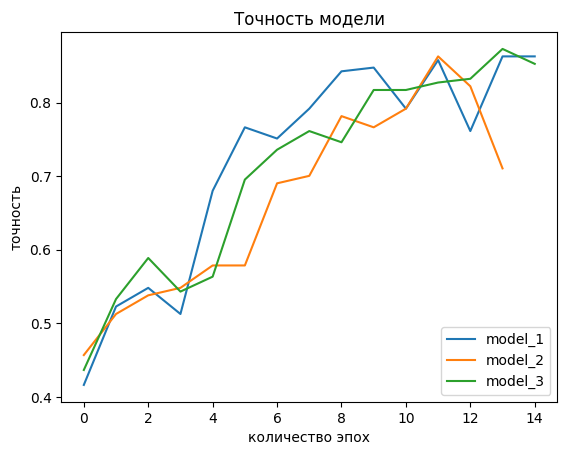

In [33]:
plt.plot(res_model['model_1'].history['val_accuracy'])
plt.plot(res_model['model_2'].history['val_accuracy'])
plt.plot(res_model['model_3'].history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['model_1', 'model_2', 'model_3'], loc='lower right')
plt.show()

Вывод. Визуально видно, что модели обучались примерно одинаково. Обучение 2 модели было остановлено на 13 эпохе, тк явно видно, что после 11 она уже переобучалась (лучшее ее значение точности было около 86%). Из всех трех моделей лучшую точность показала первая модель (86.29 %), ее и будем использовать на новых примерах.

In [36]:
#посмотрим строение model_1
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 50)                5

Модель имеет почти 6млн параметров

### Тестирование на новых примерах

In [108]:
# возьмем 10 новых данных
l2[:6]

[3, 3, 3, 1, 3, 4]

In [109]:
x = np.array(l1[:6]) 
x = x / 255

y = encoder.fit_transform(l2[:6])
y = np.array(y)
y

array([1, 1, 1, 0, 1, 2], dtype=int64)

Посмотрим на изображения разных классов

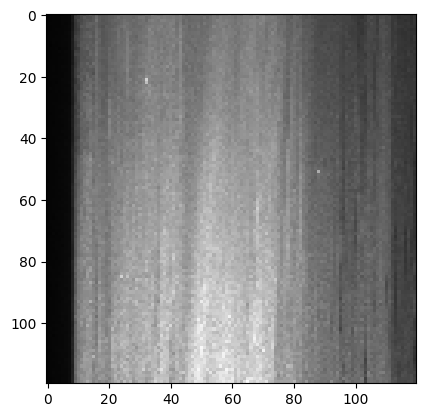

In [110]:
plt.imshow(l1[4])

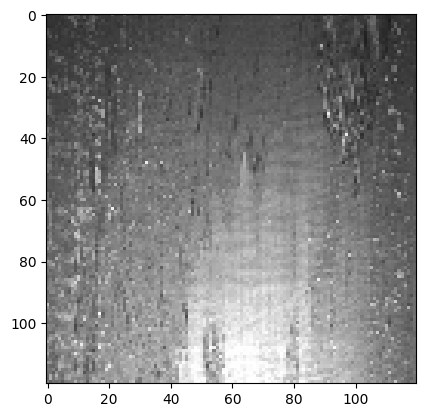

In [111]:
plt.imshow(l1[5])

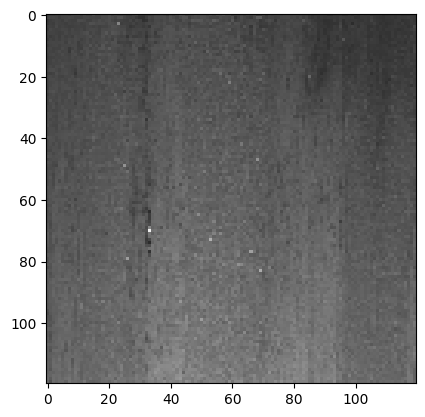

In [112]:
plt.imshow(l1[6])

In [113]:
y = to_categorical(y, 4)
y

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [114]:
predictions = np.argmax(model_3.predict(x), axis=1)
predictions

1/1 [==============================] - 0s 174ms/step


array([2, 2, 2, 0, 0, 3], dtype=int64)

Ответы: array([1, 1, 1, 0, 1, 2], dtype=int64)

Вывод: на новых данных модель не заработала, выдав только 1 правильный ответ из 6